In [1]:
import pickle
from pathlib2 import Path
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'retina'

In [2]:
from sklearn.metrics import roc_curve

In [3]:
import math

In [4]:
from numpy import random

In [5]:
PATH_TO_DATA = Path('catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/')

times = ['time%s' % i for i in range(1, 11)]
train_df = pd.read_csv(PATH_TO_DATA / 'train_sessions.csv',
                       index_col='session_id', parse_dates=times)
test_df = pd.read_csv(PATH_TO_DATA / 'test_sessions.csv',
                      index_col='session_id', parse_dates=times)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_alice = train_df[train_df['target']== 1]
#test_alice = test_df[test_df['target']== 1]
train_alice.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
251175,270,2013-02-12 16:25:10,270.0,2013-02-12 16:25:11,270.0,2013-02-12 16:32:10,21.0,2013-02-12 16:32:11,21.0,2013-02-12 16:32:24,...,2013-02-12 16:32:25,21.0,2013-02-12 16:32:25,7832.0,2013-02-12 16:32:26,30.0,2013-02-12 16:32:27,7832.0,2013-02-12 16:32:27,1
196388,29,2013-02-12 16:32:27,7832.0,2013-02-12 16:32:28,37.0,2013-02-12 16:32:29,7832.0,2013-02-12 16:32:34,7832.0,2013-02-12 16:32:35,...,2013-02-12 16:32:35,7832.0,2013-02-12 16:32:42,29.0,2013-02-12 16:32:42,7832.0,2013-02-12 16:32:51,7832.0,2013-02-12 16:32:53,1
172448,29,2013-02-12 16:32:53,7832.0,2013-02-12 16:33:11,7832.0,2013-02-12 16:33:12,29.0,2013-02-12 16:33:13,37.0,2013-02-12 16:33:15,...,2013-02-12 16:33:24,29.0,2013-02-12 16:33:24,7832.0,2013-02-12 16:33:33,29.0,2013-02-12 16:33:34,270.0,2013-02-12 16:33:46,1
70129,167,2013-02-12 16:33:50,167.0,2013-02-12 16:33:51,1515.0,2013-02-12 16:33:52,167.0,2013-02-12 16:33:52,37.0,2013-02-12 16:33:52,...,2013-02-12 16:33:52,855.0,2013-02-12 16:33:52,1515.0,2013-02-12 16:33:53,855.0,2013-02-12 16:33:53,1514.0,2013-02-12 16:33:53,1
206254,1520,2013-02-12 16:33:55,1522.0,2013-02-12 16:33:56,1522.0,2013-02-12 16:34:01,1515.0,2013-02-12 16:34:12,1515.0,2013-02-12 16:34:13,...,2013-02-12 16:34:24,1514.0,2013-02-12 16:34:24,1515.0,2013-02-12 16:34:24,1520.0,2013-02-12 16:34:25,1521.0,2013-02-12 16:34:25,1


In [6]:
train_df.shape, test_df.shape

((253561, 21), (82797, 20))

In [7]:
test_df.columns

Index(['site1', 'time1', 'site2', 'time2', 'site3', 'time3', 'site4', 'time4',
       'site5', 'time5', 'site6', 'time6', 'site7', 'time7', 'site8', 'time8',
       'site9', 'time9', 'site10', 'time10'],
      dtype='object')

In [8]:
train_df.columns

Index(['site1', 'time1', 'site2', 'time2', 'site3', 'time3', 'site4', 'time4',
       'site5', 'time5', 'site6', 'time6', 'site7', 'time7', 'site8', 'time8',
       'site9', 'time9', 'site10', 'time10', 'target'],
      dtype='object')

In [9]:
train_df.target.value_counts()

0    251264
1      2297
Name: target, dtype: int64

In [10]:
test_df.head(4)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23


In [11]:
train_alice.describe()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,target
count,2297.000000,2294.000000,2287.000000,2286.000000,2280.000000,2273.000000,2269.000000,2263.000000,2262.000000,2258.000000,2297.0
mean,3119.592947,2999.513078,2951.274158,3072.664042,2912.150439,3035.263968,3176.235346,2930.432170,3089.833333,2981.442870,1.0
std,7120.997108,6644.107233,6628.797591,6825.233710,6648.011922,6765.622736,6953.305236,6723.534647,6873.117594,6660.374884,0.0
min,1.000000,3.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,3.000000,1.0
25%,76.000000,76.000000,75.000000,76.000000,75.750000,76.000000,76.000000,76.000000,75.000000,76.000000,1.0
50%,170.000000,252.000000,162.000000,261.000000,143.500000,177.000000,240.000000,143.000000,144.500000,162.000000,1.0
75%,1519.000000,1677.000000,1522.000000,1797.500000,1521.250000,1523.000000,2077.000000,1519.000000,1569.000000,1520.000000,1.0
max,27381.000000,27387.000000,27381.000000,27379.000000,27389.000000,27389.000000,27389.000000,27388.000000,27389.000000,27381.000000,1.0


In [12]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
train_alice[sites] = train_alice[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)

# Load websites dictionary
with open(PATH_TO_DATA / 'site_dic.pkl', "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), 
                          columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

c:\python3\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


In [13]:
sites_dict.loc[77]

site    i1.ytimg.com
Name: 77, dtype: object

In [14]:
len(sites_dict), len(train_alice)

(48371, 2297)

In [15]:
top_five_sites_for_alice = pd.Series(train_alice[sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).head(5)
print(top_five_sites_for_alice)
#sites_dict.loc[top_five_sites_for_alice.drop(0).index]

77    1382
80    1354
76    1307
29     897
21     857
dtype: int64


In [16]:
top_sites = pd.Series(train_alice[sites].values.flatten()).value_counts()
len(top_sites), print(type(top_sites))

<class 'pandas.core.series.Series'>


(1054, None)

In [17]:
top_sites= pd.DataFrame(top_sites)
top_sites.rename({0:'num_visits'}, inplace=True, axis=1)

In [18]:
top_sites.head(5)

,num_visits
77,1382
80,1354
76,1307
29,897
21,857


In [19]:
top_sites = top_sites.sort_index(ascending=False)

In [20]:
top_sites.drop([0],axis=0, inplace=True)
top_sites.tail(5)

,num_visits
6,35
4,26
3,129
2,18
1,12


In [21]:
df3 = top_sites.join(sites_dict)
df3.tail(10)

,num_visits,site
12,26,storage.live.com
11,48,go.trouter.io
10,14,js.live.net
8,80,windowslive.tt.omtrdc.net
7,26,secure.shared.live.com
6,35,people.directory.live.com
4,26,mail.live.com
3,129,login.live.com
2,18,hotmail.fr
1,12,fpdownload2.macromedia.com


In [22]:
df3.sort_values(by='num_visits',ascending=True,inplace=True)


In [23]:
print(len(df3))

1053


In [24]:
df3.tail(10)

,num_visits,site
82,447,r2---sn-gxo5uxg-jqbe.googlevideo.com
75,451,s.ytimg.com
22,522,apis.google.com
879,522,r1---sn-gxo5uxg-jqbe.googlevideo.com
81,609,r4---sn-gxo5uxg-jqbe.googlevideo.com
21,857,www.google.fr
29,897,www.facebook.com
76,1307,www.youtube.com
80,1354,s.youtube.com
77,1382,i1.ytimg.com


In [25]:
# Create a separate dataframe where we will work with timestamps
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

# Find sessions' starting and ending
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)

# Calculate sessions' duration in seconds
time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

time_df.head()

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0


In [26]:
train_df.head(10)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0
242171,952,2013-01-12 08:50:22,947,2013-01-12 08:50:23,953,2013-01-12 08:50:23,946,2013-01-12 08:50:23,947,2013-01-12 08:50:24,...,2013-01-12 08:50:24,953,2013-01-12 08:50:24,955,2013-01-12 08:50:24,946,2013-01-12 08:50:25,947,2013-01-12 08:50:25,0
57157,953,2013-01-12 08:50:25,947,2013-01-12 08:50:26,946,2013-01-12 08:50:26,953,2013-01-12 08:50:26,955,2013-01-12 08:50:26,...,2013-01-12 08:50:27,953,2013-01-12 08:50:27,946,2013-01-12 08:50:27,953,2013-01-12 08:50:28,1033,2013-01-12 08:50:28,0
240201,946,2013-01-12 08:50:28,947,2013-01-12 08:50:28,954,2013-01-12 08:50:28,953,2013-01-12 08:50:29,946,2013-01-12 08:50:29,...,2013-01-12 08:50:29,946,2013-01-12 08:50:30,956,2013-01-12 08:50:30,957,2013-01-12 08:50:31,956,2013-01-12 08:50:31,0
210686,946,2013-01-12 08:50:31,956,2013-01-12 08:50:32,946,2013-01-12 08:50:32,946,2013-01-12 08:50:33,955,2013-01-12 08:50:33,...,2013-01-12 08:50:33,946,2013-01-12 08:50:34,946,2013-01-12 08:50:35,946,2013-01-12 08:50:36,948,2013-01-12 08:50:36,0


In [27]:
time_df.describe()

,target,seconds
count,253561.000000,253561.000000
mean,0.009059,138.494370
std,0.094747,295.781742
min,0.000000,0.000000
25%,0.000000,7.000000
50%,0.000000,27.000000
75%,0.000000,113.000000
max,1.000000,1800.000000


In [28]:
#need to create alice and non-alice sessions.

In [29]:
type(time_df), len(time_df)

(pandas.core.frame.DataFrame, 253561)

In [30]:
alice_df = time_df[time_df['target']==1]
alice_df.head()

,target,min,max,seconds
session_id,,,,
251175,1,2013-02-12 16:25:10,2013-02-12 16:32:27,437.0
196388,1,2013-02-12 16:32:27,2013-02-12 16:32:53,26.0
172448,1,2013-02-12 16:32:53,2013-02-12 16:33:46,53.0
70129,1,2013-02-12 16:33:50,2013-02-12 16:33:53,3.0
206254,1,2013-02-12 16:33:55,2013-02-12 16:34:25,30.0


In [31]:
alice_df.head()

,target,min,max,seconds
session_id,,,,
251175,1,2013-02-12 16:25:10,2013-02-12 16:32:27,437.0
196388,1,2013-02-12 16:32:27,2013-02-12 16:32:53,26.0
172448,1,2013-02-12 16:32:53,2013-02-12 16:33:46,53.0
70129,1,2013-02-12 16:33:50,2013-02-12 16:33:53,3.0
206254,1,2013-02-12 16:33:55,2013-02-12 16:34:25,30.0


In [32]:
alice_df.rename(columns={'seconds':'sec'}, inplace=True)

c:\python3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [33]:
alice_df.head()

,target,min,max,sec
session_id,,,,
251175,1,2013-02-12 16:25:10,2013-02-12 16:32:27,437.0
196388,1,2013-02-12 16:32:27,2013-02-12 16:32:53,26.0
172448,1,2013-02-12 16:32:53,2013-02-12 16:33:46,53.0
70129,1,2013-02-12 16:33:50,2013-02-12 16:33:53,3.0
206254,1,2013-02-12 16:33:55,2013-02-12 16:34:25,30.0


In [34]:
alice_df['minutes'] = alice_df['sec']/60

c:\python3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [35]:
alice_df.head()

,target,min,max,sec,minutes
session_id,,,,,
251175,1,2013-02-12 16:25:10,2013-02-12 16:32:27,437.0,7.283333
196388,1,2013-02-12 16:32:27,2013-02-12 16:32:53,26.0,0.433333
172448,1,2013-02-12 16:32:53,2013-02-12 16:33:46,53.0,0.883333
70129,1,2013-02-12 16:33:50,2013-02-12 16:33:53,3.0,0.050000
206254,1,2013-02-12 16:33:55,2013-02-12 16:34:25,30.0,0.500000


In [36]:
other_users = time_df[time_df['target']==0]
other_users.head()

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0


In [37]:
other_users.head()

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0


In [38]:
other_users['minutes'] = other_users['seconds']/60
other_users.head()

c:\python3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,target,min,max,seconds,minutes
session_id,,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0,0.000000
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0,29.766667
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0,0.066667
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0,0.050000
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0,0.033333


In [39]:
print("avg session for alice is : {}".format( sum(alice_df['minutes'])/ len(alice_df['minutes'])))

avg session for alice is : 0.8716078943549493


In [40]:
print( "avg session for alice is : {}".format(np.mean((alice_df['minutes'])) ))

avg session for alice is : 0.8716078943549558


In [41]:
print( "avg session for other users is {}".format(sum(other_users['minutes'] / len(other_users['minutes']))))

avg session for other users is 2.3213728720917524


In [42]:
print( "avg session for other users is {}".format( np.mean(other_users['minutes'])))

avg session for other users is 2.321372872092036


on avg,  alice's session is shorter than other users - TRUE

In [43]:
alice_df.describe().loc['max']['minutes']

29.383333333333333

In [44]:
def approx_same(a,b):
    return abs(a-b)/ max(a,b) <= 0.05
    

more than 1% of all sessions in the dataset belong to Alice

In [45]:
alice_df.shape

(2297, 5)

In [46]:
train_df.shape

(253561, 21)

In [47]:
(2297*100)/253561

0.905896411514389

we have < 1% of sessions belonging to alice

maximum durations of Alice's and other users' sessions are approximately the same?

In [48]:
approx_same(alice_df.describe().loc['max']['minutes'], other_users.describe().loc['max']['minutes'])

True

In [49]:
alice_df.describe().loc['max']['minutes']

29.383333333333333

In [50]:
other_users.describe().loc['max']['minutes']

30.0

minimum durations of Alice's and other users' sessions are approximately the same?

In [51]:
approx_same(alice_df.describe().loc['min']['minutes'], other_users.describe().loc['min']['minutes'])

c:\python3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


False

In [52]:
alice_df.describe().loc['min']['minutes']

0.0

In [53]:
other_users.describe().loc['min']['minutes']

0.0

TRUE - MAX & MIN DURATIONS ARE APPROX SAME!!!!!!!!!!!!!!!!!!!!!!!!!!!

standard deviation of Alice's sessions duration is approximately the same as for non-Alice's sessions

In [54]:
approx_same(alice_df.describe().loc['std']['minutes'], other_users.describe().loc['std']['minutes'])

False

In [55]:
alice_df.describe().loc['std']['minutes']

2.555150234212393

In [56]:
other_users.describe().loc['std']['minutes']

4.944225295308388

less than a quarter of Alice's sessions are greater than or equal to 40 seconds

In [57]:
alice_df.columns

Index(['target', 'min', 'max', 'sec', 'minutes'], dtype='object')

In [58]:
len(alice_df.sec)

2297

In [59]:
len(alice_df[alice_df['sec']>=40])

554

In [60]:
print("less than a quarter of alice sessions are greater than 40seconds ,  25% ={0} % , so it is {1}".format(  (554*100/2297) , (554*100/2297)<25 ))

less than a quarter of alice sessions are greater than 40seconds ,  25% =24.11841532433609 % , so it is True


## train + test = full_df

In [61]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

In [62]:
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [63]:
sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for 
# (make sure you understand which of the `csr_matrix` constructors is used here)
# a further toy example will help you with it
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

In [64]:
full_sites.index.value_counts()

2047      2
35985     2
60317     2
62366     2
64415     2
66464     2
68513     2
70562     2
72611     2
74660     2
76709     2
78758     2
80807     2
1152      2
3201      2
5250      2
7299      2
9348      2
11397     2
13446     2
15495     2
17544     2
19593     2
21642     2
23691     2
25740     2
27789     2
29838     2
31887     2
58268     2
         ..
112458    1
110409    1
108360    1
122695    1
120646    1
118597    1
116548    1
87894     1
131479    1
172419    1
186764    1
170372    1
168325    1
166278    1
164231    1
194952    1
192905    1
190858    1
188811    1
184717    1
133526    1
182670    1
180623    1
145808    1
143761    1
141714    1
139667    1
137620    1
135573    1
124739    1
Name: session_id, Length: 253561, dtype: int64

In [65]:
full_sites[full_sites.index == 146670]

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
146670,947,950,948,947,950,952,946,951,946,947


In [66]:
full_sites_sparse.shape

(336358, 48371)

In [67]:
print('{0} elements * {1} bytes = {2} bytes'.format(full_sites_sparse.count_nonzero(), 8, 
                                                    full_sites_sparse.count_nonzero() * 8))
# Or just like this:
print('sparse_matrix_size = {0} bytes'.format(full_sites_sparse.data.nbytes))

1866898 elements * 8 bytes = 14935184 bytes
sparse_matrix_size = 7467592 bytes


In [68]:
data = [1] * 9

# To do this, you need to correctly distribute the ones in cells
# Indices - website ids, i.e. columns of a new matrix. We will sum ones up grouping them by sessions (ids)
indices = [1, 0, 0, 1, 3, 1, 2, 3, 4]

# Indices for the division into rows (sessions)
# For example, line 0 is the elements between the indices [0; 3) - the rightmost value is not included
# Line 1 is the elements between the indices [3; 6)
# Line 2 is the elements between the indices [6; 9) 
indptr = [0, 3, 6, 9]

# Aggregate these three variables into a tuple and compose a matrix
# To display this matrix on the screen transform it into the usual "dense" matrix
dense_m = csr_matrix((data, indices, indptr)).todense()

In [69]:
dense_m = pd.DataFrame(dense_m)

In [70]:
dense_m

,0,1,2,3,4
0,2,1,0,0,0
1,0,2,0,1,0
2,0,0,1,1,1


In [71]:
dense_m = dense_m.drop(columns=[0])

In [72]:
dense_m

,1,2,3,4
0,1,0,0,0
1,2,0,1,0
2,0,1,1,1


non_zero elements = 6, zero-elem = 6, total = 12

sparcity = 1 - (nonzero/total) = 1 - (6/12) = 1- 0.5 = 0.5, 50%

In [73]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [74]:
%%time
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_sparse[:idx_split, :]

# Calculate metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9195245587148385
Wall time: 12.7 s


In [75]:
%%time
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_sparse[:idx_split, :]

# Calculate metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9195245587148385
Wall time: 12.3 s


In [76]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [77]:
# Train the model on the whole training data set
# Use random_state=17 for repeatability
# Parameter C=1 by default, but here we set it explicitly
lr = LogisticRegression(C=1.0, random_state=17, solver='liblinear').fit(X_train, y_train)

# Make a prediction for test data set
X_test = full_sites_sparse[idx_split:,:]
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'baseline_1.csv')

## Adding start_month

In [78]:
full_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,945,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,946,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,952,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22


In [79]:
full_df[full_df.index == 21669]

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
21669,21,2014-05-05 15:28:30,42279,2014-05-05 15:28:31,76,2014-05-05 15:28:31,21,2014-05-05 15:28:31,229,2014-05-05 15:28:31,21,2014-05-05 15:28:32,234,2014-05-05 15:28:32,42279,2014-05-05 15:28:32,76,2014-05-05 15:28:33,42279,2014-05-05 15:28:33


In [80]:
full_new_feat = pd.DataFrame(index=full_df.index)

# Add start_month feature
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 
                                                      100 * ts.year + ts.month).astype('float64')

Plot the graph of the number of Alice sessions versus the new feature, start_month. Choose the correct statemen

In [81]:
full_new_feat.head()

,start_month
session_id,
21669,201301.0
54843,201301.0
77292,201301.0
114021,201301.0
146670,201301.0


In [82]:
full_new_feat['start_month'] = full_new_feat['start_month'].astype('category')

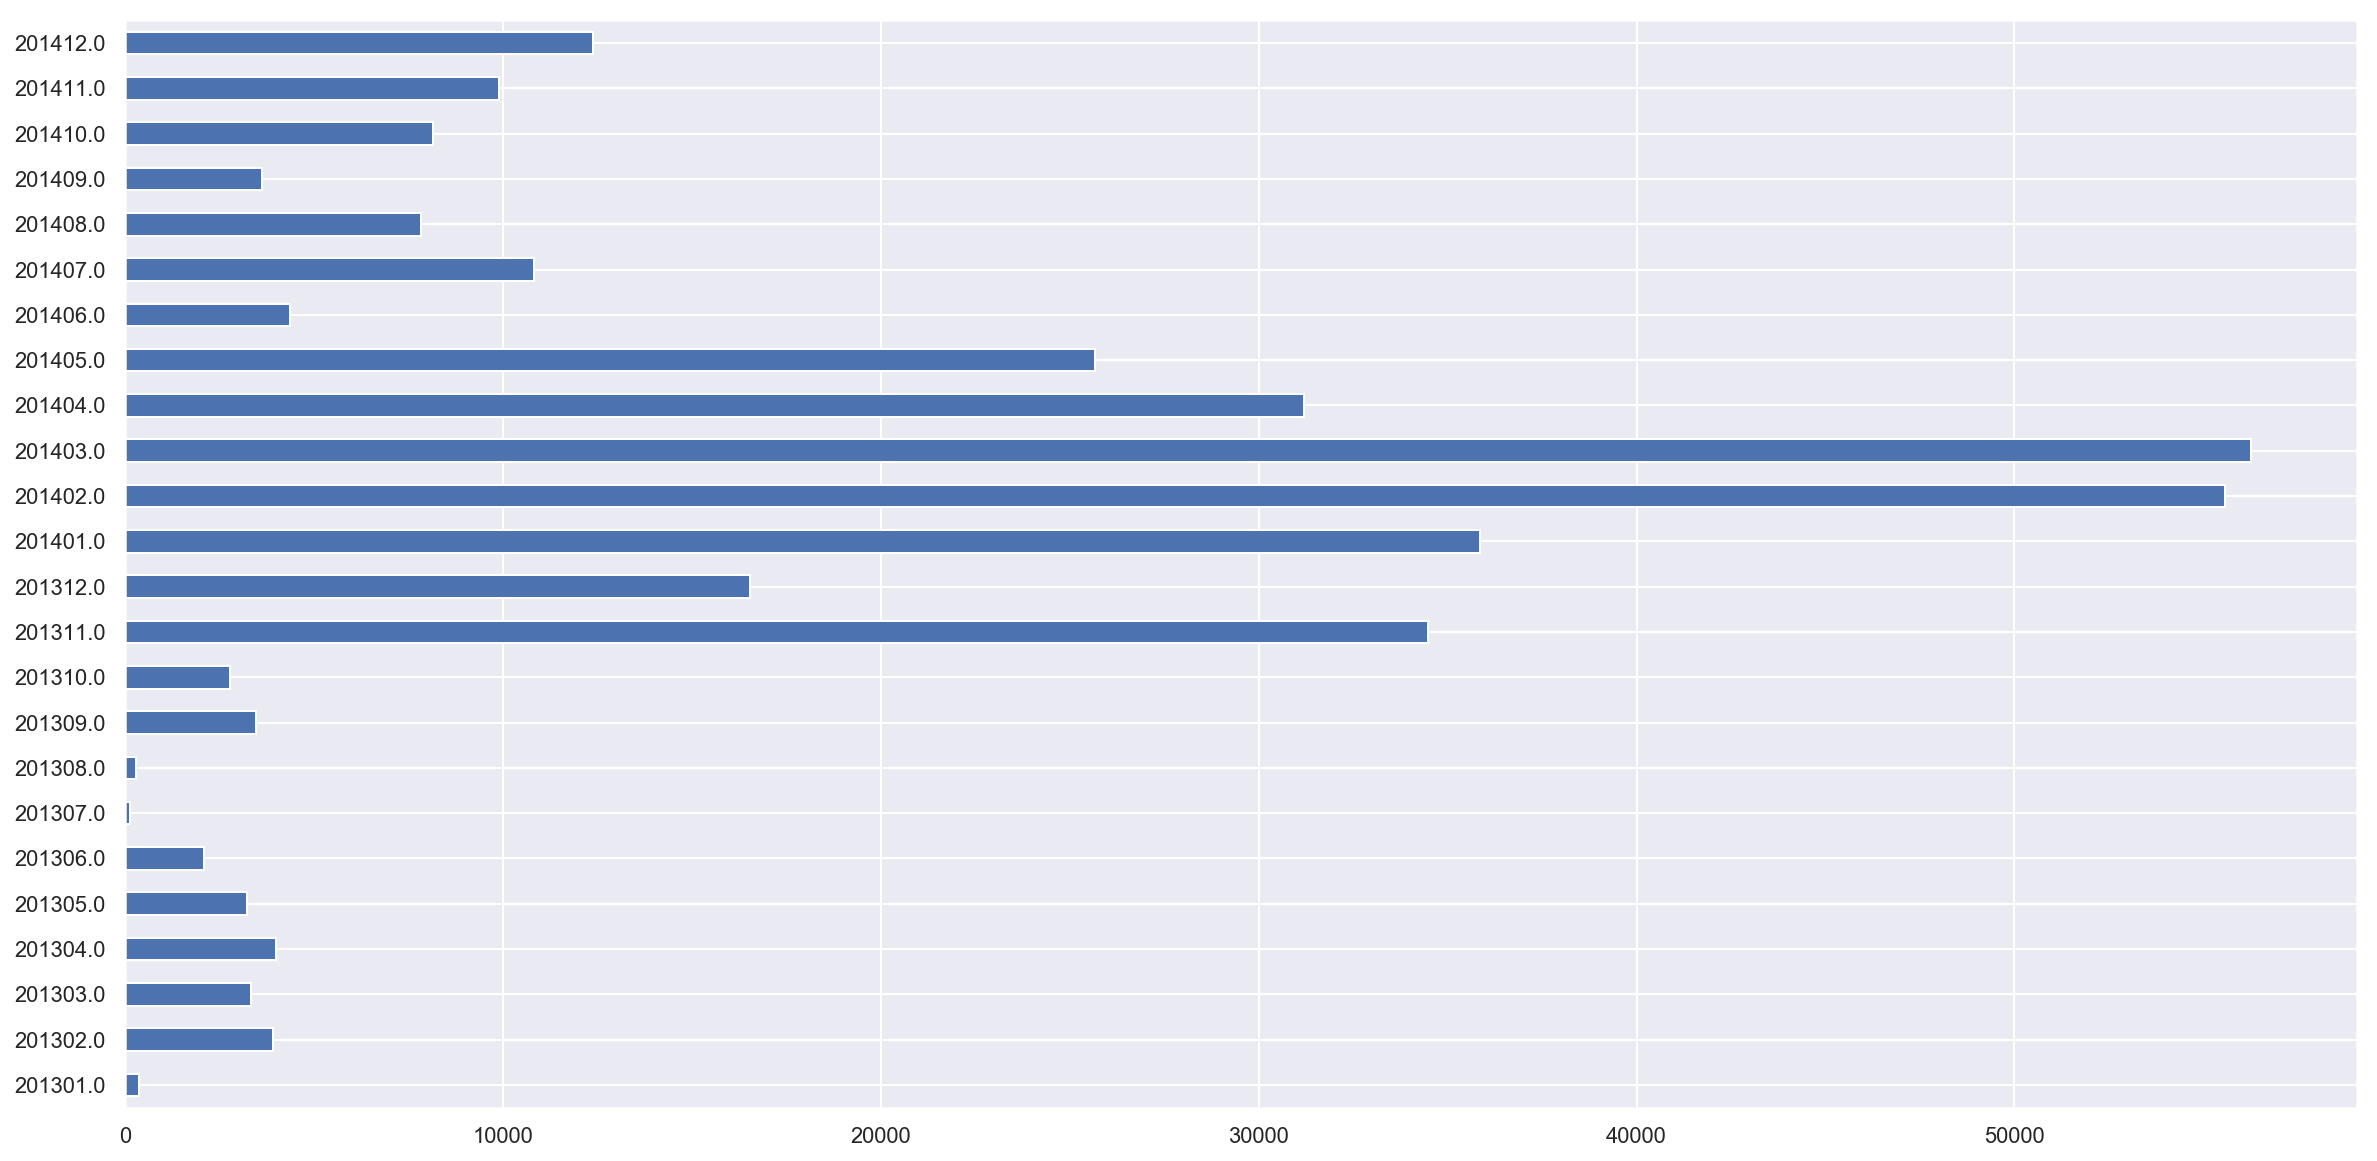

In [83]:
plt.figure(figsize=(20,10))
full_new_feat['start_month'].value_counts().sort_index().plot(kind='barh')

answer - From the beginning of 2013 to mid-2014, the number of Alice's sessions per month increased

#### calculating ROC auc without scaling for start_month

In [84]:
# Add the new feature to the sparse matrix
tmp = full_new_feat[['start_month']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.7508354860175162


#### calculating ROC auc with scaling for start_month

In [85]:
# Add the new standardized feature to the sparse matrix
tmp = StandardScaler().fit_transform(full_new_feat[['start_month']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

c:\python3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype category were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\python3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype category were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0.9196827643967169


## Adding new feature - n_unique_visits to both train & test

In [86]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0


In [87]:
train_df['start_month']  = train_df['time1'].apply(lambda ts: 100 * ts.year + ts.month).astype('float64')

In [88]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,site7,time7,site8,time8,site9,time9,site10,time10,target,start_month
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,0,NaT,0,NaT,0,NaT,0,NaT,0,201301.0
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,0,NaT,0,NaT,0,NaT,0,NaT,0,201301.0
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0,201301.0
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0,201301.0
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0,201301.0


In [89]:
train_df['n_unique_visits'] = train_df[['site1','site2','site3','site4','site5','site6','site7','site8','site9','site10']].nunique(axis=1)

In [90]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time7,site8,time8,site9,time9,site10,time10,target,start_month,n_unique_visits
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,201301.0,3
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,201301.0,3
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0,201301.0,6
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0,201301.0,5
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0,201301.0,6


 Add to the training set a new feature "n_unique_sites" – the number of the unique web-sites in a session. Calculate how the quality on the validation set has changed

In [91]:
test_df['start_month']  = test_df['time1'].apply(lambda ts: 100 * ts.year + ts.month).astype('float64')

In [92]:
test_df['n_unique_visits'] = test_df[['site1','site2','site3','site4','site5','site6','site7','site8','site9','site10']].nunique(axis=1)
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,site7,time7,site8,time8,site9,time9,site10,time10,start_month,n_unique_visits
session_id,,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35,2014-10-04 11:19:53,22,2014-10-04 11:19:54,321,2014-10-04 11:19:54,23,2014-10-04 11:19:54,...,6730,2014-10-04 11:19:54,21,2014-10-04 11:19:54,44582,2014-10-04 11:20:00,15336,2014-10-04 11:20:00,201410.0,10
2,782,2014-07-03 11:00:28,782,2014-07-03 11:00:53,782,2014-07-03 11:00:58,782,2014-07-03 11:01:06,782,2014-07-03 11:01:09,...,782,2014-07-03 11:01:23,782,2014-07-03 11:01:29,782,2014-07-03 11:01:30,782,2014-07-03 11:01:53,201407.0,1
3,55,2014-12-05 15:55:12,55,2014-12-05 15:55:13,55,2014-12-05 15:55:14,55,2014-12-05 15:56:15,55,2014-12-05 15:56:16,...,55,2014-12-05 15:56:18,55,2014-12-05 15:56:19,1445,2014-12-05 15:56:33,1445,2014-12-05 15:56:36,201412.0,2
4,1023,2014-11-04 10:03:19,1022,2014-11-04 10:03:19,50,2014-11-04 10:03:20,222,2014-11-04 10:03:21,202,2014-11-04 10:03:21,...,50,2014-11-04 10:03:22,48,2014-11-04 10:03:22,48,2014-11-04 10:03:23,3374,2014-11-04 10:03:23,201411.0,7
5,301,2014-05-16 15:05:31,301,2014-05-16 15:05:32,301,2014-05-16 15:05:33,66,2014-05-16 15:05:39,67,2014-05-16 15:05:40,...,70,2014-05-16 15:05:40,68,2014-05-16 15:05:40,71,2014-05-16 15:05:40,167,2014-05-16 15:05:44,201405.0,8


In [93]:
len(test_df.columns), len( train_df.columns)

(22, 23)

### concatenating train + test = full_df with new features

In [94]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df_with_new_features = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

In [95]:
full_sites = full_df_with_new_features[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [96]:
sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for 
# (make sure you understand which of the `csr_matrix` constructors is used here)
# a further toy example will help you with it
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

### calculating without scaler for start_month

In [97]:
tmp = full_df_with_new_features[['start_month']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.7508354860175162


### calculating with scaler for start_month

In [98]:
# Add the new standardized feature to the sparse matrix
tmp = StandardScaler().fit_transform(full_df_with_new_features[['start_month']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9196827643967169


0.7508354860175162


### adding start_hour to full_new_features - no need to repeat adding this feature for train,test

In [99]:
full_df_with_new_features.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,site7,time7,site8,time8,site9,time9,site10,time10,start_month,n_unique_visits
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,0,NaT,0,NaT,0,NaT,0,NaT,201301.0,3
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,0,NaT,0,NaT,0,NaT,0,NaT,201301.0,3
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,201301.0,6
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,201301.0,5
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,201301.0,6


In [100]:
full_df_with_new_features['start_hour'] = full_df_with_new_features['time1'].apply(lambda time: time.hour)

In [101]:
x = full_df_with_new_features['time1'].iloc[21669]
x

Timestamp('2013-10-12 09:53:49')

In [102]:
type(x.hour)

int

In [104]:
my_own_exper['start_'] = full_df_with_new_features['time1'].apply(lambda time: time.hour + time)

ValueError: Cannot add integral value to Timestamp without freq.

In [105]:
full_df_with_new_features['morning'] = full_df_with_new_features['start_hour'].apply(lambda x: 1 if x <= 11 else 0)

In [106]:
full_df_with_new_features.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,site8,time8,site9,time9,site10,time10,start_month,n_unique_visits,start_hour,morning
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,0,NaT,0,NaT,0,NaT,201301.0,3,8,1
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,0,NaT,0,NaT,0,NaT,201301.0,3,8,1
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,201301.0,6,8,1
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,201301.0,5,8,1
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,201301.0,6,8,1


## Calculating ROC AUC without scaling

In [107]:
tmp = full_df_with_new_features[['start_month', 'start_hour']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.13543115879019754


In [108]:
tmp = full_df_with_new_features[['start_hour', 'morning', 'n_unique_visits']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9536741156181616


In [109]:
tmp = full_df_with_new_features[['morning', 'n_unique_visits']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.944490638088199


In [110]:
tmp = full_df_with_new_features[['start_hour', 'n_unique_visits']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.952393676120362


In [111]:
tmp = full_df_with_new_features[['n_unique_visits']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9163665589418817


In [112]:
tmp = full_df_with_new_features[['morning','n_unique_visits']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.944490638088199


In [113]:
tmp = full_df_with_new_features[['start_month','start_hour', 'morning', 'n_unique_visits']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.13422212319271143


In [114]:
tmp = full_df_with_new_features[['morning']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9472937317942698


In [115]:
tmp = full_df_with_new_features[['start_hour']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9561191331053239


## Calculating ROC AUC with scaling

In [116]:
# Add the new standardized feature to the sparse matrix
tmp = StandardScaler().fit_transform(full_df_with_new_features[['start_month', 'start_hour', 'morning', 'n_unique_visits']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

c:\python3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\python3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0.9553219908313165


In [117]:
# Add the new standardized feature to the sparse matrix
tmp = StandardScaler().fit_transform(full_df_with_new_features[['start_hour', 'morning', 'n_unique_visits']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

c:\python3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\python3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0.9536261104589655


In [118]:
# Add the new standardized feature to the sparse matrix
tmp = StandardScaler().fit_transform(full_df_with_new_features[['morning', 'n_unique_visits']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

c:\python3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\python3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0.9440069634653565


In [119]:
# Add the new standardized feature to the sparse matrix
tmp = StandardScaler().fit_transform(full_df_with_new_features[['start_hour',  'n_unique_visits']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

c:\python3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\python3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0.9517895357206692


In [120]:
# Add the new standardized feature to the sparse matrix
tmp = StandardScaler().fit_transform(full_df_with_new_features[['start_hour',  'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

c:\python3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\python3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0.9572502735388317


In [121]:
# Add the new standardized feature to the sparse matrix
tmp = StandardScaler().fit_transform(full_df_with_new_features[['morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

c:\python3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\python3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0.947403479438092


In [122]:
# Add the new standardized feature to the sparse matrix
tmp = StandardScaler().fit_transform(full_df_with_new_features[['start_hour']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

c:\python3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\python3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0.9565884665642557


## regularization and tuning

In [123]:
# Compose the training set
%time
tmp_scaled = StandardScaler().fit_transform(full_df_with_new_features[['start_month', 
                                                           'start_hour', 
                                                           'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))

# Capture the quality with default parameters
score_C_1 = get_auc_lr_valid(X_train, y_train)
print(score_C_1)

Wall time: 0 ns


c:\python3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\python3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0.9591516099541565


In [124]:
Cs = np.logspace(-3, 1, 10)
score_dict = dict()
for c in Cs:
    each_c_score = get_auc_lr_valid(X_train, y_train,C=c)
    score_dict[c] = each_c_score
    print("the C value: {0:.3f} and its score: {1:.4f}".format(c,each_c_score))

the C value: 0.001 and its score: 0.8230
the C value: 0.003 and its score: 0.8965
the C value: 0.008 and its score: 0.9390
the C value: 0.022 and its score: 0.9564
the C value: 0.060 and its score: 0.9607
the C value: 0.167 and its score: 0.9612
the C value: 0.464 and its score: 0.9603
the C value: 1.292 and its score: 0.9587
the C value: 3.594 and its score: 0.9558
the C value: 10.000 and its score: 0.9513


In [125]:
len(Cs)

10

In [126]:
score_dict.keys()

dict_keys([0.001, 0.0027825594022071257, 0.007742636826811269, 0.021544346900318832, 0.05994842503189409, 0.1668100537200059, 0.46415888336127775, 1.2915496650148828, 3.593813663804626, 10.0])

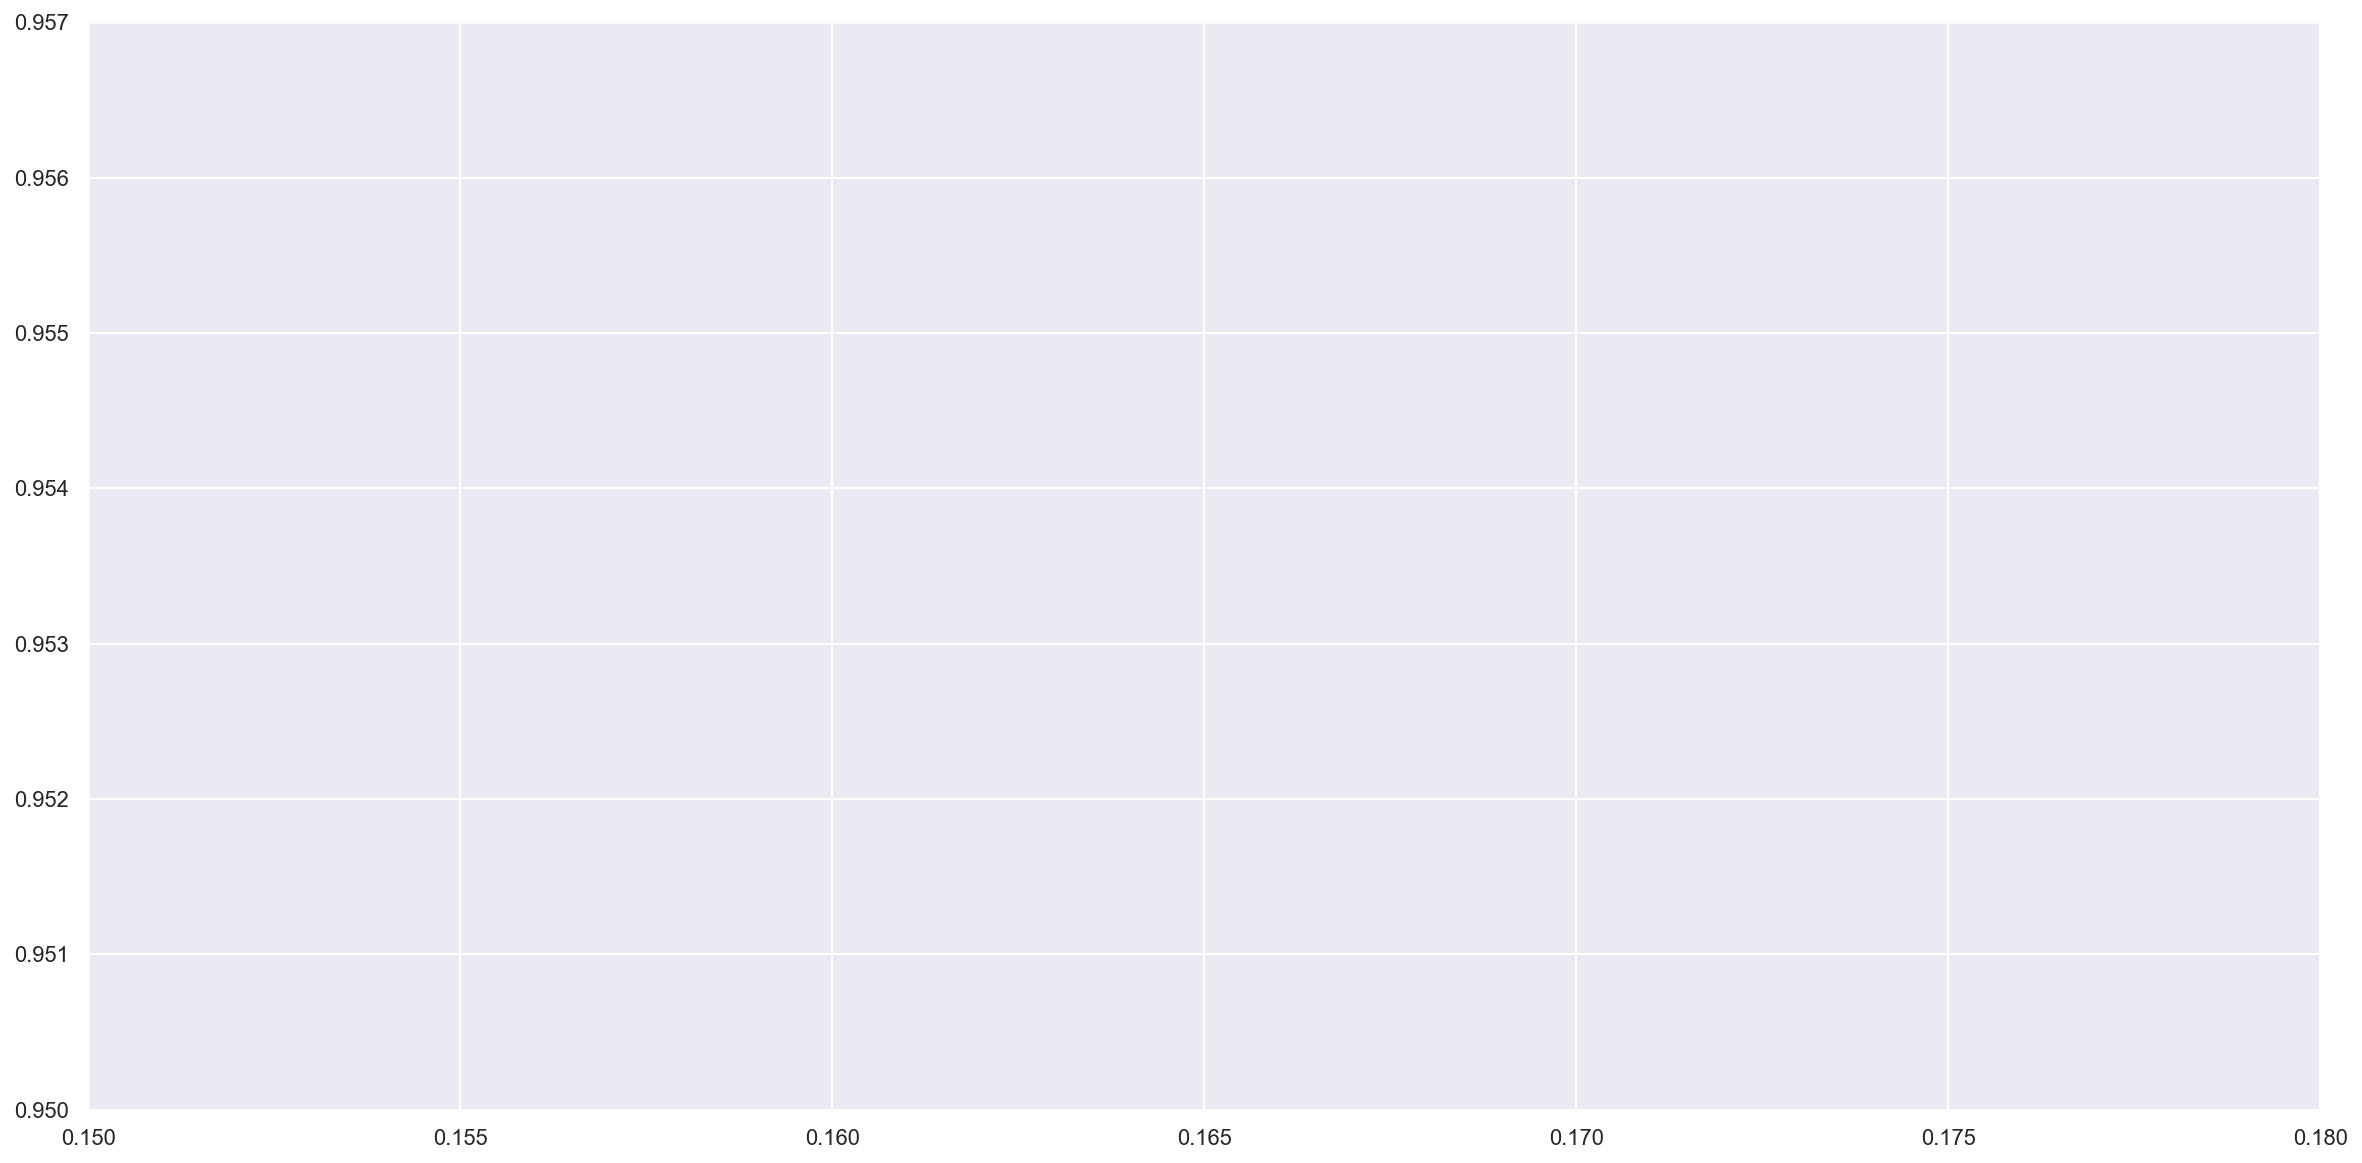

In [127]:
fig,ax = plt.subplots(figsize=(20,10))
plt.plot( list(score_dict.keys()), list(score_dict.values()))
plt.xlim(0.15,0.18)
plt.ylim(0.95,0.957)
plt.show()

In [128]:
# Prepare the training and test data
tmp_scaled = StandardScaler().fit_transform(full_df_with_new_features[['start_month', 'start_hour', 
                                                           'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:], 
                            tmp_scaled[idx_split:,:]]))

# Train the model on the whole training data set using optimal regularization parameter
lr = LogisticRegression(C=0.1668100537200059, random_state=17, solver='liblinear').fit(X_train, y_train)

# Make a prediction for the test set
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'baseline_2.csv')

c:\python3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\python3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


# Part 2


In [129]:
def impute_nan_with_median(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table 

In [130]:
data = pd.read_csv('credit_scoring_sample.csv', sep=",",header='infer')
data['DebtRatio'] = data['DebtRatio'].replace(',','.', regex=True).astype(float)
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [ ]:
data.dtypes

In [ ]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target:')
data['SeriousDlqin2yrs'].value_counts(normalize=True)

In [ ]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

In [ ]:
table = impute_nan_with_median(data)

In [ ]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

Question 8. Make an interval estimate based on the bootstrap (2000 samples) of the average income (MonthlyIncome) of customers who had overdue loan payments, and of those who paid in time, make 80% confidence interval. Use target value (SeriousDlqin2yrs) to split data. Find the difference between the lower limit of the derived interval for those who paid in time and the upper limit for those who are overdue. So, you are asked to build 80% intervals for the income of "good" customers [good_income_lower,good_income_upper] and for "bad" - [bad_income_lower,bad_income_upper] and find the difference good_income_lower−bad_income_upper.

Use the example from the article. Set np.random.seed(17). Round your answer to the closest integer.

In [ ]:
len(data)

In [10]:
import numpy as np
import np.random
def get_bootstrap_samples(data, n_samples):
    """Generate bootstrap samples using the bootstrap method."""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    """Produce an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries
# Save the data about the loyal and former customers to split the dataset
good_income = data[data['SeriousDlqin2yrs']== 0]['MonthlyIncome'].values
bad_income = data[[['SeriousDlqin2yrs']== 1]['MonthlyIncome'].values
# Set the seed for reproducibility of the results
np.random.seed(17)
# Generate the samples using bootstrapping and calculate the mean for each of them
loyal_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(good_income, 2000)]
churn_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(bad_income, 2000)]
# Print the resulting interval estimates
print("Service calls from loyal: mean interval", 
      stat_intervals(loyal_mean_scores, 0.05))
print("Service calls from churn: mean interval", 
      stat_intervals(churn_mean_scores, 0.05))

SyntaxError: invalid syntax (<ipython-input-10-7bc9bbd383cb>, line 16)